This is just a snippet of the code I used for some of the main figures in "CO2 and Orbitally Driven Oxygen Isotope Variability in the Early Eocene" published in Climate of the Past, 2024.

In [1]:
# Imports and functions

import os
from datetime import datetime
from pathlib import Path
from typing import List, Union, Tuple, Optional
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.util as cutil
import warnings
from matplotlib.figure import Axes
import colorsys
import time
from contextlib import ContextDecorator
from functools import reduce
from cartopy.geodesic import Geodesic
from dateutil.relativedelta import relativedelta
from matplotlib.figure import Figure
from shapely.geometry import LineString
from enum import Enum
import xesmf as xe
from dataclasses import dataclass
from matplotlib import ticker

# IMPORT ENTIRE CESM_TOOLBOX MANUALLY #

# consts.py

DAY_IN_SECONDS = 24 * 60 * 60
YEAR_IN_SECONDS = 365 * DAY_IN_SECONDS
KELVIN_OFFSET = 273.15
SEASONS = ["DJF", "MAM", "JJA", "SON"]
MONTHS = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
MONTHS_ABR = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
G = 9.807
EARTH_RADIUS = 6.3781 * 10 ** 6

# utils.py

Color = Tuple[float, float, float]
IMAGE_DIR = os.getenv("SAVED_FIG_DIR", default=".")
GEODESIC = Geodesic()


def set_image_dir(image_dir):
    global IMAGE_DIR
    IMAGE_DIR = image_dir


def cyclitize(dataset: xr.DataArray) -> xr.DataArray:
    """
    Take a dataarray and add cyclic longitude points for easy plotting. Return
    a new dataarray to make life easier for everyone.
    """
    cyclic_data, cyclic_lon = cutil.add_cyclic_point(dataset, coord=dataset.lon)
    new_dataset = xr.DataArray(
        cyclic_data,
        coords={
            **dataset.coords,
            "lon": cyclic_lon,
        },
        dims=dataset.dims,
        attrs=dataset.attrs,
        name=dataset.name,
    )
    return new_dataset


def fix_dates(
    climatology_data: xr.Dataset, date_coord: str = "time", fake_year: int = 1994
) -> xr.Dataset:
    """
    Prescribe dates for a given dataset since the timestamps are meaningless in
    the output file and only the order of the months matter (e.g. the first
    month is always January)
    fake_year - the year to set the dates to, this should be a NON-leap year
    as per https://www.cesm.ucar.edu/models/cesm1.0/cesm/cesm_doc_1_0_4/x3088.html
    which states that leap years are not being used
    """
    fixed_dates = [
        datetime(fake_year, 1, 1) + relativedelta(months=i) for i in range(12)
    ]
    update_dict = {
        date_coord: fixed_dates,
    }
    return climatology_data.assign_coords(**update_dict)


def to_lower_snake_case(*args: List[str]) -> str:
    """
    Convenience function for converting one or more strings to lower snake case. Useful
    for creating filenames.
    """
    return "_".join([input_str.lower().replace(" ", "_") for input_str in args])


def get_max_colormap_value(data: xr.DataArray) -> float:
    """
    Get the maximum absolute value from a dataset. Useful for setting the vmax and vmin
    values when creating a colormap for plotting in matplotlib.
    """
    return max(np.abs(np.max(data)), np.abs(np.min(data)))


def adjust_lightness(color: Union[Color, str], amount: float = 1.5) -> Color:
    """
    Change the lightness of the provided color. The second optional color determines
    how much to lighten the color. The higher the value, the lighter it will be.
    Adapted from: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib/49601444
    """
    try:
        c = colors.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*colors.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


def savefig(
    fig: Figure,
    filename: str,
    dpi: int = 300,
    version: Optional[int] = None,
    facecolor: Optional[str] = "white",
) -> None:
    """
    Save a figure to a specified directory and version it to ensure that it doesn't overwrite any
    previously saved figures.
    """
    if facecolor is not None:
        fig.patch.set_facecolor(facecolor)
    figure_path = os.path.join(
        IMAGE_DIR, f"{filename}-v{str(version or 1).zfill(3)}.png"
    )
    if version is None:
        version = 1
        while os.path.exists(figure_path):
            version += 1
            if version > 100:
                raise Exception(
                    f"To many files named {filename} in directory, tried up to version {version}"
                )
            figure_path = os.path.join(
                IMAGE_DIR, f"{filename}-v{str(version or 1).zfill(3)}.png"
            )
    fig.savefig(figure_path, dpi=dpi)


class timer(ContextDecorator):
    """
    Use as an annotation to wrap a function and create a timer for that function
    to measure wall clock timing. Can also be used as a contextmanager:
    with timer(name="potato"):
        time.sleep(2) # do stuff
    @timer(name="funcname")
    def test():
        time.sleep(3) # do stuff
    """

    def __init__(self, name="timer", format="s"):
        self.name = name
        self.format = format

    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *exc):
        elapsed = time.time() - self.start

        if format == "ms":
            elapsed *= 1000

        print(f"{self.name} took {elapsed:.2f}{self.format}")
        return False


def combine_datasets(
    datasets: List[xr.Dataset], labels=None, new_coord="experiment"
) -> xr.Dataset:
    """
    Merge similarly dimensioned dataset together along a new artifical coordinate
    (default "experiment").
    """
    if labels is None:
        labels = list(range(len(datasets)))
    datasets = [
        dataset.expand_dims({new_coord: 1}).assign_coords({new_coord: [label]})
        for (label, dataset) in zip(labels, datasets)
    ]
    merged_data = xr.merge(datasets)
    return merged_data


def central_lon(extent: List[Union[int, float]]) -> float:
    """
    Return the central longitude given an array defining extents such as [x0, x1, y0, y1]. This is useful for
    ensuring that your projection is always centered over your extent area to reduce distortions.
    """
    return sum(extent[:2]) / 2


def get_region_mask_from_point(
    grid: xr.Dataset,
    lat: float,
    lon: float,
    lon_offset: float = 5,
    lat_offset: float = 2.5,
):
    """
    Return lat/lon mask around a given lat/lon pair. Assuming the lat/lon pair is in the center of a grid point, this
    mask should provide a 3x3 grid cell mask over that point (with default lon/lat offsets). Useful for conducting
    point analysis.
    """
    return (
        (grid.lat < lat + lat_offset)
        & (grid.lat > lat - lat_offset)
        & (grid.lon < lon + lon_offset)
        & (grid.lon > lon - lon_offset)
    )


def find_closest_idx(values: np.ndarray, to_find: float) -> int:
    """Returns the index of the value that is closest to the one you're trying to find."""
    return (np.abs(values - to_find)).argmin()


def find_closest_cell(
    grid: xr.Dataset, lat: float, lon: float
) -> Tuple[Tuple[int, int], Tuple[float, float]]:
    """
    Given a grid that has lat/lon, find the closest cell center that match the lat/lon pair provided.
    """
    lat_idx = find_closest_idx(grid.lat.values, lat)
    lon_idx = find_closest_idx(grid.lon.values, lon)
    grid_lat, grid_lon = grid.lat.values[lat_idx], grid.lon.values[lon_idx]
    return (lat_idx, lon_idx), (grid_lat, grid_lon)


def find_all_closest_cells(grid: xr.Dataset, lat_lon_pairs: np.ndarray):
    """
    For each lat/lon pair find the grid point that is closest to the pair, compile a list and return it.
    """
    indicies = [
        (find_closest_idx(grid.lat.values, lat), find_closest_idx(grid.lon.values, lon))
        for (lat, lon) in lat_lon_pairs
    ]
    return np.array(
        [
            (grid.lat.values[lat_idx], grid.lon.values[lon_idx])
            for (lat_idx, lon_idx) in indicies
        ]
    )


def great_circle_dist(
    point1: Tuple[float, float], point2: Tuple[float, float]
) -> float:
    """
    Finds geodesic great cricle distance between two pairs of lat/lon points. The "true" distance between the points
    on a sphere. Or at least as close an approximation as possible.
    Returns values in meters.
    """
    line = LineString([point1, point2])
    return GEODESIC.geometry_length(line)


def zonal_weighted(latitudes: xr.DataArray) -> xr.DataArray:
    """
    Calculate the zonal weights by area for a given set of latitudes. These weights should be used prior to calculating
    averages across latitudes to properly weight differences in area across and rectilinear grid.
    """
    coslat = np.cos(np.deg2rad(latitudes))
    return coslat / coslat.mean(dim="lat")


def std_err(data: np.ndarray, axis: Tuple) -> np.ndarray:
    """
    Computes the standard error of a given set of data over the given axis. This is useful when combined with the
    xarray.reduce function, e.g.:
        zonal_mean_std_err = data.TEMP.reduce(std_err, dim=["time", "lon"])
    """
    shapes = [data.shape[a] for a in axis]
    size = reduce(lambda x, y: x * y, shapes)
    return np.std(data, axis=axis) / np.sqrt(size)

# paleoclimate.py

def plot_land(ax: Axes, land_frac: xr.DataArray, threshold=0.5):
    """
    Plot the outline of grid cells that contain a land fraction greater than the
    provided threshold. Useful for plotting the paleo outline of continents.
    land_frac: A DataArray from CESM that contains the fraction of land at each
    given grid cell
    threshold: The fraction of land that needs to be in a grid cell to be considered
    in the outline
    """
    land = land_frac >= threshold
    cyclic_land, cyclic_land_lon = cutil.add_cyclic_point(land, coord=land.lon)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ax.contour(
            cyclic_land_lon,
            land.lat,
            cyclic_land,
            transform=ccrs.PlateCarree(),
            colors="black",
            levels=[1],
            linewidths=0.5,
        )


def clustering(cluster_algo, data, reshape=True):
    stacked = data.stack(z=("lat", "lon"))
    reshaped = stacked.values
    if reshape:
        reshaped = np.reshape(reshaped, (-1, 1))

    clusters = cluster_algo.fit(reshaped)
    labelled_array = xr.DataArray(
        clusters.labels_, dims=stacked.dims, coords=stacked.coords, attrs=stacked.attrs
    )
    return labelled_array.unstack()


def get_value_from_datasets(
    datasets: List[Union[xr.Dataset, xr.DataArray]],
    function_name: str = "min",
    placeholder_coord: str = "experiment",
) -> xr.Dataset:
    datasets = [
        dataset.expand_dims({placeholder_coord: 1}).assign_coords(
            {placeholder_coord: [i]}
        )
        for (i, dataset) in enumerate(datasets)
    ]
    merged_data = xr.merge(datasets)
    return getattr(merged_data, function_name)(dim=placeholder_coord)

# pop.py

class GridType(Enum):
    U = "U"
    T = "T"


def regrid(
    dataset: xr.DataArray,
    output_dims: Tuple[int, int],
    grid_type: GridType = GridType.T,
    interpolation_method: str = "bilinear",
    periodic: bool = True,
    reuse_weights: bool = True,
) -> xr.DataArray:
    """
    This function takes in a dataarray that is in the curvilinear grid that POP
    uses and regrids it to a rectilinear grid using xesmf. The dimensions of
    the output grid are given as a tuple in degrees latitude and longitude
    (respectively). POP data should be regridded before plotting and before
    performing a zonal average.
    """
    lon_str, lat_str = f"{grid_type.value}LONG", f"{grid_type.value}LAT"
    output_grid = xe.util.grid_global(*output_dims)
    input_data = dataset.rename({lon_str: "lon", lat_str: "lat"})
    regridder = xe.Regridder(
        input_data,
        output_grid,
        interpolation_method,
        periodic=periodic,
        reuse_weights=reuse_weights,
    )
    output_data = regridder(input_data)
    return output_data


def delta_18o(pop_data: xr.Dataset) -> xr.DataArray:
    d18o = (pop_data.R18O - 1) * 1000
    d18o = d18o.assign_attrs(units="per thousand")
    return d18o


def read_pop_data(
    path: str, with_fixed_dates: bool = True, with_extra_data: bool = False
) -> xr.Dataset:
    data = xr.open_dataset(path)
    if with_fixed_dates:
        data = fix_dates(data)
    if with_extra_data:
        data = data.assign(d18o=delta_18o(data))
    return data

# proxy_data.py

class ProxySource(Enum):
    jiang_2020 = "jiang_2020"
    van_dijk_2020 = "van_dijk_2020"


class ProxyLocality(Enum):
    marine = "marine"
    terrestrial = "terrestrial"


@dataclass()
class ProxyData:
    lat: float
    d18o: float
    d18o_std: float
    source: ProxySource
    locality: ProxyLocality
    name: str
    lon: Optional[float] = None
    temp: Optional[float] = None
    temp_std: Optional[float] = None
    glassy: bool = False
        
# plotting.py

def map_difference_plot(
    datasets: List[xr.DataArray],
    titles: List[str],
    data_label: str,
    land: xr.DataArray,
    data_func=None,
    target_projection=ccrs.PlateCarree,
    input_projection=ccrs.PlateCarree,
    should_cyclitize=True,
    figsize=(16, 4), # was 20, 4
    should_regrid=False,
    regrid_size=(1, 1),
    cmap="PuOr",
    norm=None,
    diff_cmap="PuOr",
    constrained_layout=True,
    should_diff=True,
    levels=20,
    extent=None,
    land_threshold=0.75,
) -> Figure:
    # Data maniupulation here
    if data_func is not None:
        datasets = [data_func(d) for d in datasets]
    base_data = datasets[0]
    if should_diff:
        diffs = [d - base_data for d in datasets[1:]]
    else:
        diffs = datasets[1:]
    if should_cyclitize:
        base_data = cyclitize(base_data)
        diffs = [cyclitize(d) for d in diffs]
    if should_regrid:
        base_data = regrid(base_data, regrid_size)
        diffs = [regrid(d, regrid_size) for d in diffs]

    # Plot stuff here
    target_proj, input_proj = target_projection(), input_projection()
    num_plots = len(datasets)
    subplots = [int(f"1{num_plots}{i + 2}") for i in range(len(datasets) - 1)]

    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_plots,
        subplot_kw={"projection": target_proj},
        figsize=figsize,
        constrained_layout=constrained_layout,
    )
    contour = axes[0].contourf(
        base_data.lon,
        base_data.lat,
        base_data,
        transform=input_proj,
        cmap=cmap,
        norm=norm,
        levels=levels,
    )
    axes[0].gridlines(draw_labels=True, linestyle="--", alpha=0.5)
    plot_land(axes[0], land, threshold=land_threshold)
    axes[0].set_title(titles[0], size=15)
    cbar = fig.colorbar(contour, ax=axes[0], pad=0.05)
    cbar.set_label(data_label)
    if extent:
        axes[0].set_extent(extent, crs=ccrs.PlateCarree())
    else:
        axes[0].set_global()

    vmax = max(np.nanmax(d.values) for d in diffs)
    vmin = min(np.nanmin(d.values) for d in diffs)
    if should_diff:
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax

    bounds = np.linspace(vmin, vmax, levels)
    for data, title, subplot, ax in zip(diffs, titles[1:], subplots, axes[1:].flat):
        diff_contour = ax.contourf(
            data.lon,
            data.lat,
            data,
            transform=input_proj,
            cmap=diff_cmap,
            vmin=vmin,
            vmax=vmax,
            levels=levels,
        )
        ax.gridlines(draw_labels=True, linestyle="--", alpha=0.5)
        plot_land(ax, land, threshold=land_threshold)
        ax.set_title(f"{title} - {titles[0]}", size=15)
        if extent:
            ax.set_extent(extent, crs=ccrs.PlateCarree())
        else:
            ax.set_global()

    cbar = fig.colorbar(diff_contour, ax=axes[1:].ravel().tolist())
    cbar.set_label(data_label)
    return fig


def seasonal_difference_plot(
    base_dataset: xr.DataArray,
    dataset: xr.DataArray,
    data_label: str,
    land: xr.DataArray,
    data_func=None,
    input_projection=ccrs.PlateCarree,
    output_projection=ccrs.PlateCarree,
    extent=None,
    diff_cmap="RdBu_r",
    levels=20,
    figsize=(24, 12),
    should_cyclitize=True,
    draw_labels=True,
    time_func=np.mean,
    mask: xr.DataArray = None,
    land_threshold=0.75,
) -> Figure:
    if data_func:
        base_dataset = data_func(base_dataset)
        dataset = data_func(dataset)
    grouped_base = base_dataset.groupby("time.season").reduce(time_func, dim="time")
    grouped_data = dataset.groupby("time.season").reduce(time_func, dim="time")
    diffs = [
        grouped_data.sel(season=season) - grouped_base.sel(season=season)
        for season in SEASONS
    ]
    if should_cyclitize:
        diffs = [cyclitize(d) for d in diffs]
    if mask is not None:
        diffs = [d.where(mask) for d in diffs]


    vmax = max(
        max(abs(float(np.nanmax(d.values))), abs(float(np.nanmin(d.values))))
        for d in diffs
    )
  
    

    central_longitude = central_lon(extent) if extent else 0

    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        subplot_kw={
            "projection": output_projection(central_longitude=central_longitude)
        },
        figsize=figsize,
    )
    bounds = np.linspace(-vmax, vmax, levels)
    for season, ax, diff in zip(SEASONS, axes.flat, diffs):
        diff_contour = ax.contourf(
            diff.lon,
            diff.lat,
            diff,
            transform=input_projection(),
            cmap=diff_cmap,
            levels=levels,
            vmin=-vmax,
            vmax=vmax,
        )
        plot_land(ax, land, threshold=land_threshold)
        if extent:
            ax.set_extent(extent)
        else:
            ax.set_global()
        ax.gridlines(draw_labels=draw_labels, alpha=0.5)
        ax.set_title(season, size=20)

    cbar = fig.colorbar(diff_contour, ax=axes.ravel().tolist())
    cbar.set_label(data_label)
    return fig


def seasonal_plot(
    dataset: xr.DataArray,
    data_label: str,
    land: xr.DataArray,
    data_func=None,
    input_projection=ccrs.PlateCarree,
    output_projection=ccrs.PlateCarree,
    extent=None,
    cmap="viridis",
    levels=20,
    figsize=(24, 12),
    should_cyclitize=True,
    should_norm=True,
    draw_labels=True,
    time_func=np.mean,
    mask: xr.DataArray = None,
) -> Figure:
    if data_func:
        dataset = data_func(dataset)
    grouped_data = dataset.groupby("time.season").reduce(time_func, dim="time")
    season_data = [grouped_data.sel(season=season) for season in SEASONS]
    if should_cyclitize:
        season_data = [cyclitize(d) for d in season_data]
    if mask is not None:
        season_data = [d.where(mask) for d in season_data]

    vmax = max(np.nanmax(d.values) for d in season_data)
    vmin = min(np.nanmin(d.values) for d in season_data)
    if should_norm:
        vmax = max(abs(vmin), abs(vmax))
        vmin = -vmax

    central_longitude = central_lon(extent) if extent else 0

    fig, axes = plt.subplots(
        nrows=2,
        ncols=2,
        subplot_kw={
            "projection": output_projection(central_longitude=central_longitude)
        },
        figsize=figsize,
    )
    bounds = np.linspace(vmin, vmax, levels)
    for season, ax, diff in zip(SEASONS, axes.flat, season_data):
        season_contour = ax.contourf(
            diff.lon,
            diff.lat,
            diff,
            transform=input_projection(),
            cmap=cmap,
            levels=bounds,
            vmin=vmin,
            vmax=vmax,
        )
        plot_land(ax, land)
        if extent:
            ax.set_extent(extent)
        else:
            ax.set_global()
        ax.gridlines(draw_labels=draw_labels, alpha=0.5)
        ax.set_title(season, size=20)

    cbar = fig.colorbar(season_contour, ax=axes.ravel().tolist())
    cbar.set_label(data_label)
    return fig


@ticker.FuncFormatter
def lat_formatter(x, pos):
    if x > 0:
        return f"{x:.0f}N"
    elif x < 0:
        return f"{abs(x):.0f}S"
    else:
        return f"{x:.0f}"


def line_plot_style(ax):
    ax.grid(alpha=0.4)
    ax.tick_params(axis="x", direction="in")
    ax.tick_params(axis="y", direction="in")
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(20)


def zonal_plot_style(ax):
    line_plot_style(ax)
    ax.set_xlim([-90, 90])
    ax.xaxis.set_major_formatter(lat_formatter)


def month_plot_style(ax):
    line_plot_style(ax)
    ax.set_xlim([0, 11])
    
# cam.py

def delta_18O(cam_data: xr.Dataset) -> xr.DataArray:
    """
    Compute the d18O of precipitation from CAM output.
    """
    p16O = (
        cam_data.PRECRC_H216Or 
        + cam_data.PRECSC_H216Os
        + cam_data.PRECRL_H216OR
        + cam_data.PRECSL_H216OS
    )
    p18O = (
        cam_data.PRECRC_H218Or
        + cam_data.PRECSC_H218Os
        + cam_data.PRECRL_H218OR
        + cam_data.PRECSL_H218OS
    )
    d18Op = (p18O / p16O - 1) * 1000
    d18Op.attrs["units"] = "per mil"
    d18Op.attrs["name"] = "$\\delta^{18}O$ of precipitation$"
    return d18Op


def total_precip(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculate total precipitation from convection and large scale movement.
    """
    precip = dataset.PRECL + dataset.PRECC
    precip.attrs["units"] = "m/s"
    precip.attrs["name"] = "total precipitation"
    return precip


def total_precip_mm(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculate total precipitation from convection and large scale movement.
    """
    precip = (dataset.PRECL + dataset.PRECC) * DAY_IN_SECONDS * 1000
    precip.attrs["units"] = "mm/day"
    precip.attrs["name"] = "total precipitation"
    return precip


def precip_weighted_d18o(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculate d18O weighted by total precipitation for a given dataset where
    d18O has already be calculated.
    """
    d18Op = dataset.d18o * (dataset.PRECT / dataset.PRECT.sum(dim="time"))
    d18Op.attrs["units"] = "per mil"
    d18Op.attrs["name"] = "$\\delta^{18}O_p$ weighted by precipitation"
    return d18Op


def delta_d(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculate delta D (dD) of precipitation for a given dataset and cam output.
    """
    p16o = (
        dataset.PRECRC_H216Or
        + dataset.PRECSC_H216Os
        + dataset.PRECRL_H216OR
        + dataset.PRECSL_H216OS
    )
    Dp = (
        dataset.PRECRC_HDOr
        + dataset.PRECSC_HDOs
        + dataset.PRECRL_HDOR
        + dataset.PRECSL_HDOS
    )
    dDp = (Dp / p16o - 1.0) * 1000.0
    dDp.attrs["units"] = "per mil"
    dDp.attrs["name"] = "$\\delta D$ of precipitation"
    return dDp


def elevation(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculate elevation (in meters) from surface geopotential height.
    """
    phis = dataset.PHIS.max(dim="time")
    elevation = (phis * EARTH_RADIUS) / (G * EARTH_RADIUS - phis)
    elevation.attrs["units"] = "m"
    elevation.attrs["name"] = "elevation"
    return elevation


def net_precip(dataset: xr.Dataset) -> xr.DataArray:
    """
    Calculates the net precipitation by determining the evaportion from the
    QFLX data attribute.
    """
    precip = dataset.PRECTmm - dataset.QFLX * DAY_IN_SECONDS
    precip.attrs["units"] = "mm/day"
    precip.attrs["name"] = "net precipitation (precipitation - evaporation)"
    return precip


def read_cam_data(
    path: str,
    with_fixed_dates: bool = True,
    with_extra_data: bool = True,
) -> xr.Dataset:
    """
    Reads in a cam dataset and performs some common operations. Namely,
    precribing dates, calculating total precipitation, calculating d18O
    """
    data = xr.open_dataset(path)
    if with_fixed_dates:
        data = fix_dates(data)
    if with_extra_data:
        data = data.assign(
            d18o=delta_18O(data),
            PRECT=total_precip(data),
            PRECTmm=total_precip_mm(data),
            TSC=(data.TS - KELVIN_OFFSET).assign_attrs(units="C", name="temperature"),
            ELE=elevation(data),
        )
        data = data.assign(
            d18o_weighted=precip_weighted_d18o(data), NET_PRECT=net_precip(data)
        )
    return data


def plot_cam_mask(cam_data, land, projection=ccrs.PlateCarree):
    mean_TS = cam_data.TS.mean(dim="time")

    def wrapped(mask, contour=False):
        data = cyclitize(mean_TS.where(mask))
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection=projection())
        if contour:
            ax.contourf(data.lon, data.lat, data, transform=ccrs.PlateCarree())
        else:
            ax.pcolormesh(data.lon, data.lat, data, transform=ccrs.PlateCarree())
        plot_land(ax, land)
        ax.gridlines(draw_labels=True, alpha=0.5)
        plt.show()

    return wrapped

# eocene_orbital.py

PROXY_DATA = [
    ProxyData(
        lon=-4.75,
        lat=32.25,
        d18o=-1.76,
        d18o_std=0.11,
        temp=20.74,
        temp_std=0.52,
        glassy=False,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="Alamedilla",
    ),
    ProxyData(
        lon=--55.55,
        lat=38.45,
        d18o=-3.44,
        d18o_std=0.5,
        temp=28.16,
        temp_std=2.57,
        glassy=True,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="Bass River",
    ),
    ProxyData(
        lon=-173.95,
        lat=-62.45,
        d18o=-2.41,
        d18o_std=0.39,
        temp=20.54,
        temp_std=1.87,
        glassy=False,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="DSDP 277",
    ),
    ProxyData(
        lon=-10.95,
        lat=41.95,
        d18o=-2.24,
        d18o_std=0.39,
        temp=22.13,
        temp_std=1.87,
        glassy=True,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="DSDP 401",
    ),
    ProxyData(
        lon=-7.75,
        lat=-34.95,
        d18o=-1.46,
        d18o_std=0.13,
        temp=19.74,
        temp_std=0.63,
        glassy=False,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="DSDP 527",
    ),
    ProxyData(
        lon=-15.65,
        lat=43.75,
        d18o=-2.39,
        d18o_std=0.38,
        temp=22.36,
        temp_std=1.89,
        glassy=False,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="DSDP 549",
    ),
    ProxyData(
        lon=-103.75,
        lat=42.25,
        d18o=-2.88,
        d18o_std=0.24,
        temp=22.02,
        temp_std=1.15,
        glassy=True,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="Lodo Gulch",
    ),
    ProxyData(
        lon=-56.75,
        lat=37.65,
        d18o=-3.51,
        d18o_std=0.41,
        temp=28.5,
        temp_std=2.12,
        glassy=True,
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
        name="Millville",
    ),
    ProxyData(
        lon=0.55,
        lat=-64.0,
        d18o=-1.52,
        d18o_std=0.06,
        temp=16.49,
        temp_std=0.28,
        glassy=False,
        name="ODP 689",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=-1.35,
        lat=-65.05,
        d18o=-1.83,
        d18o_std=0.53,
        temp=17.96,
        temp_std=2.52,
        glassy=False,
        name="ODP 690B",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=-143.85,
        lat=4.85,
        d18o=-3.82,
        d18o_std=0.41,
        temp=31.07,
        temp_std=2.11,
        glassy=False,
        name="ODP 865",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=-161.45,
        lat=22.2,
        d18o=-1.77,
        d18o_std=0.25,
        temp=20.78,
        temp_std=1.22,
        glassy=False,
        name="ODP 1209",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=34.15,
        lat=-18.65,
        d18o=-3.44,
        d18o_std=0.35,
        temp=30.15,
        temp_std=1.81,
        glassy=True,
        name="Tanzania TDP14",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=-102.8,
        lat=41.15,
        d18o=-3.21,
        d18o_std=0.12,
        temp=23.67,
        temp_std=0.59,
        glassy=True,
        name="Tumey Gulch",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lon=-56.45,
        lat=38.65,
        d18o=-3.63,
        d18o_std=0.29,
        temp=29.07,
        temp_std=1.47,
        glassy=True,
        name="Wilson Lake",
        source=ProxySource.jiang_2020,
        locality=ProxyLocality.marine,
    ),
    ProxyData(
        lat=50.62,
        d18o=-7.7,
        d18o_std=2.07,
        name="Faroe",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=35.97,
        d18o=-5.5,
        d18o_std=2.06,
        name="Alberhill",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=78.04,
        d18o=-12.9,
        d18o_std=6.44,
        name="Arctci",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=34.21,
        d18o=-2,
        d18o_std=2.25,
        name="Arkansas",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=50.9,
        d18o=-6.8,
        d18o_std=2.3,
        name="Blum",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=62.1,
        d18o=-7.5,
        d18o_std=2.51,
        name="Alaska",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=-3.09,
        d18o=-0.3,
        d18o_std=2.29,
        name="Colombia2",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=41.5,
        d18o=-4.6,
        d18o_std=2.9,
        name="Colorado",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=45.3,
        d18o=-3.3,
        d18o_std=2.32,
        name="Hanna",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
    ProxyData(
        lat=37.71,
        d18o=-2.6,
        d18o_std=3.07,
        name="France",
        source=ProxySource.van_dijk_2020,
        locality=ProxyLocality.terrestrial,
    ),
]

In [2]:
# load in atmospheric data

DATA_PATH = f"/glade/work/juliacam/PETM/"

cam_OrbMaxN_3x = read_cam_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.OrbMaxN.01.cam.h0.2601-2700.climo.nc")
cam_OrbMaxS_3x = read_cam_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.OrbMaxS.01.cam.h0.2601-2700.climo.nc")

cam_OrbMaxN_6x = read_cam_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.OrbMaxN.01.cam.h0.2601-2700.climo.nc")
cam_OrbMaxS_6x = read_cam_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.OrbMaxS.01.cam.h0.2601-2700.climo.nc")

land = cam_OrbMaxN_3x.LANDFRAC.isel(time=0)

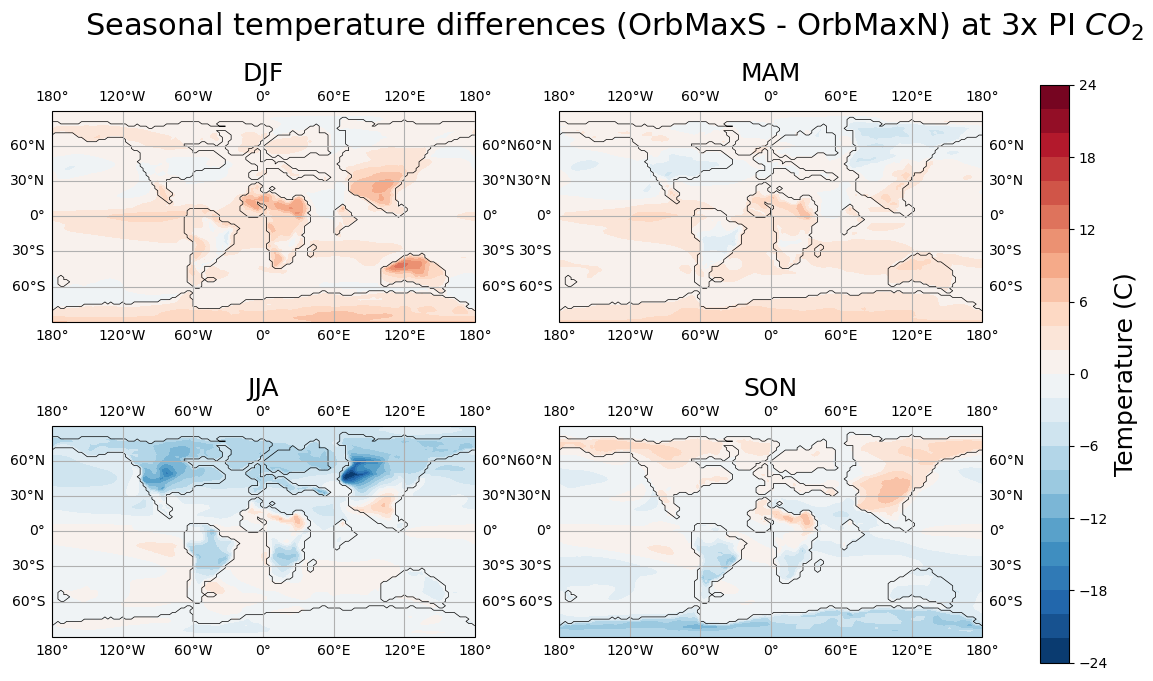

In [3]:
# temperature plots at lower CO2

grouped_orbmod_temp = cyclitize(cam_OrbMaxN_3x.TSC.groupby("time.season").mean(dim="time"))
grouped_orbmaxn_temp = cyclitize(cam_OrbMaxS_3x.TSC.groupby("time.season").mean(dim="time"))
diffs = [grouped_orbmaxn_temp.sel(season=season) - grouped_orbmod_temp.sel(season=season) for season in SEASONS]
diffs = [cyclitize(d) for d in diffs]
vmax = max(max(abs(float(d.max())), abs(float(d.min()))) for d in diffs)

fig, axes = plt.subplots(ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(15, 7.5))
bounds = np.linspace(-24, 24, 25)
contours = []
for season, ax, diff in zip(SEASONS, axes.flat, diffs):
    contour = ax.contourf(
        diff.lon,
        diff.lat,
        diff,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        levels=bounds,
        vmin=-24,
        vmax=24,
    )
    contours.append(contour)
    plot_land(ax, land)
    ax.set_global()
    ax.gridlines(draw_labels=True, alpha=1)
    ax.set_title(season, size=18)

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label("Temperature (C)",size=18)
fig.suptitle("Seasonal temperature differences (OrbMaxS - OrbMaxN) at 3x PI $CO_2$", size=22)
fig.savefig('fig02')
plt.show()

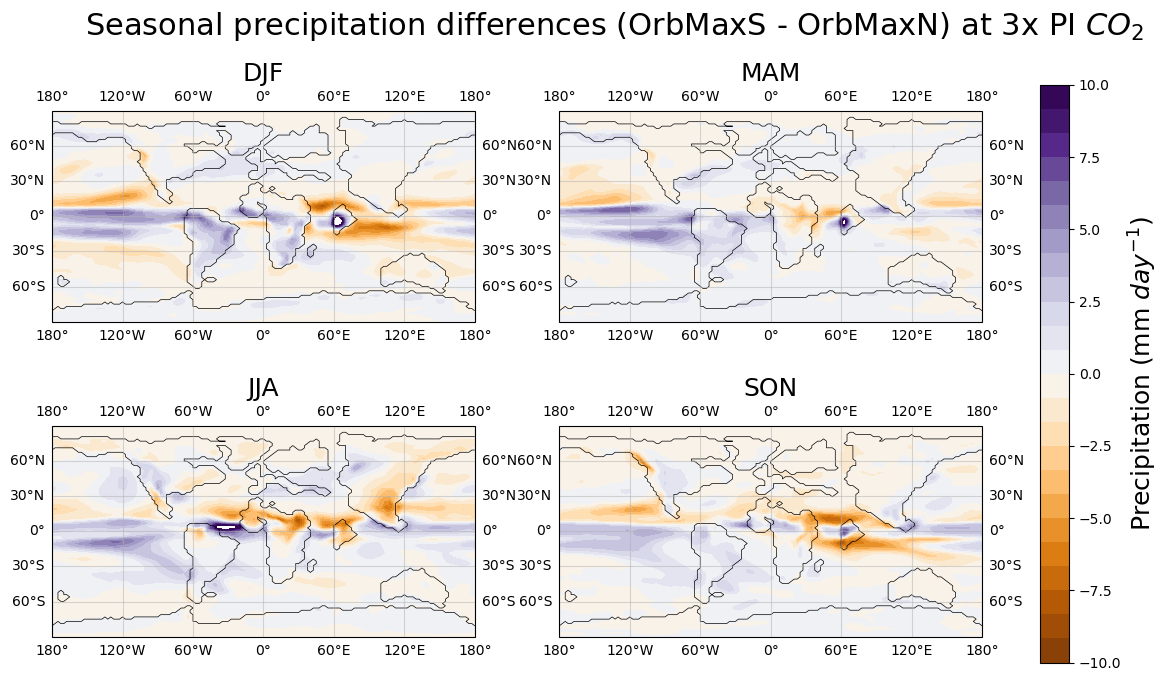

In [4]:
# precipitation plots at lower CO2

grouped_orbmaxn_precip = cyclitize(cam_OrbMaxN_3x.PRECTmm.groupby("time.season").mean(dim="time"))
grouped_orbmaxs_precip = cyclitize(cam_OrbMaxS_3x.PRECTmm.groupby("time.season").mean(dim="time"))
diffs = [(grouped_orbmaxs_precip.sel(season=season)) - (grouped_orbmaxn_precip.sel(season=season)) for season in SEASONS]
diffs = [cyclitize(d) for d in diffs]
vmax = max(max(abs(float(d.max())), abs(float(d.min()))) for d in diffs)

fig, axes = plt.subplots(ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(15, 7.5))
bounds = np.linspace(-10, 10, 25)
for season, ax, diff in zip(SEASONS, axes.flat, diffs):
    contour = ax.contourf(
        diff.lon,
        diff.lat,
        diff,
        transform=ccrs.PlateCarree(),
        cmap="PuOr",
        levels=bounds,
        vmin=-10,
        vmax=10,
    )
    plot_land(ax, land)
    ax.set_global()
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_title(season, size=18)

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label("Precipitation (mm $day^{-1}$)",size=18)
fig.suptitle("Seasonal precipitation differences (OrbMaxS - OrbMaxN) at 3x PI $CO_2$", size=22)
fig.savefig('fig03')
plt.show()

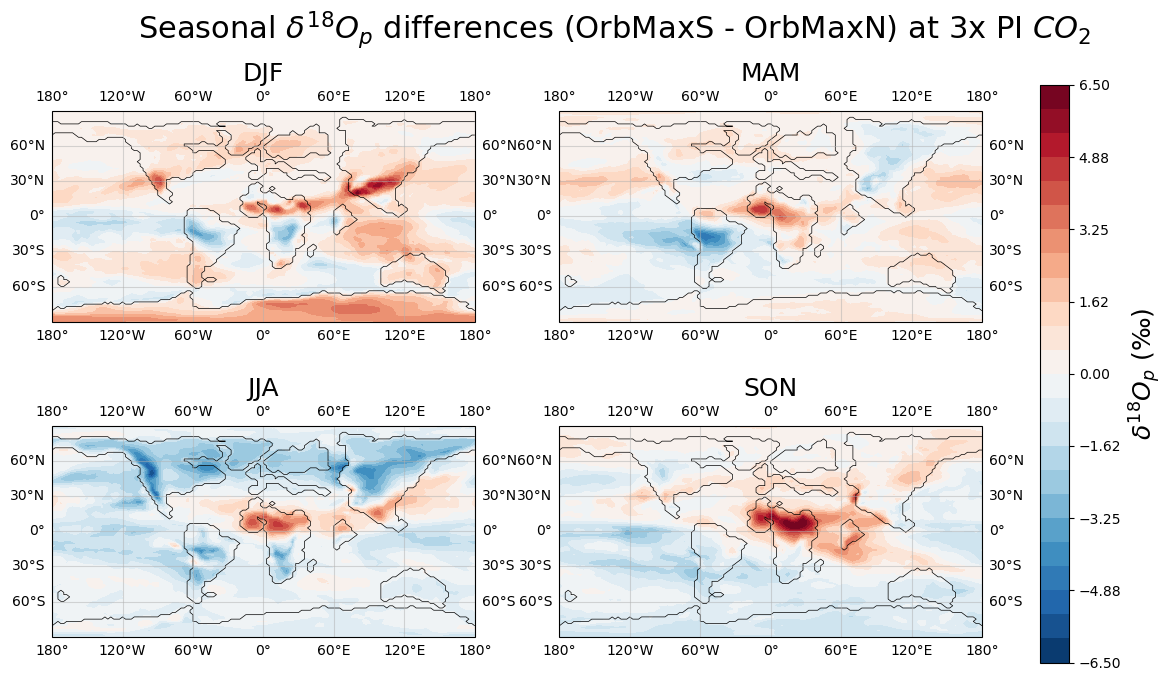

In [5]:
# water isotope plots at lower CO2

grouped_orbmaxn_d18o_w = cyclitize(cam_OrbMaxN_3x[["d18o", "PRECT"]].groupby("time.season").apply(precip_weighted_d18o).groupby("time.season").reduce(np.sum, dim="time"))
grouped_orbmaxs_d18o_w = cyclitize(cam_OrbMaxS_3x[["d18o", "PRECT"]].groupby("time.season").apply(precip_weighted_d18o).groupby("time.season").reduce(np.sum, dim="time"))
diffs = [grouped_orbmaxs_d18o_w.sel(season=season) - grouped_orbmaxn_d18o_w.sel(season=season) for season in SEASONS]
diffs = [cyclitize(d) for d in diffs]
vmax = max(max(abs(float(d.max())), abs(float(d.min()))) for d in diffs)

fig, axes = plt.subplots(ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(15,7.5))
bounds = np.linspace(-6.5, 6.5, 25)
contours = []
for season, ax, diff in zip(SEASONS, axes.flat, diffs):
    contour = ax.contourf(
        diff.lon,
        diff.lat,
        diff,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        levels=bounds,
        vmin=-6.5,
        vmax=6.5,
    )
    contours.append(contour)
    plot_land(ax, land)
    ax.set_global()
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_title(season, size=18)

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label("$\delta^{18}O_p$ ($\perthousand$)",size=18)
fig.suptitle("Seasonal $\delta^{18}O_p$ differences (OrbMaxS - OrbMaxN) at 3x PI $CO_2$", size=22)
fig.savefig("3x-d18o-orbit")
plt.show()

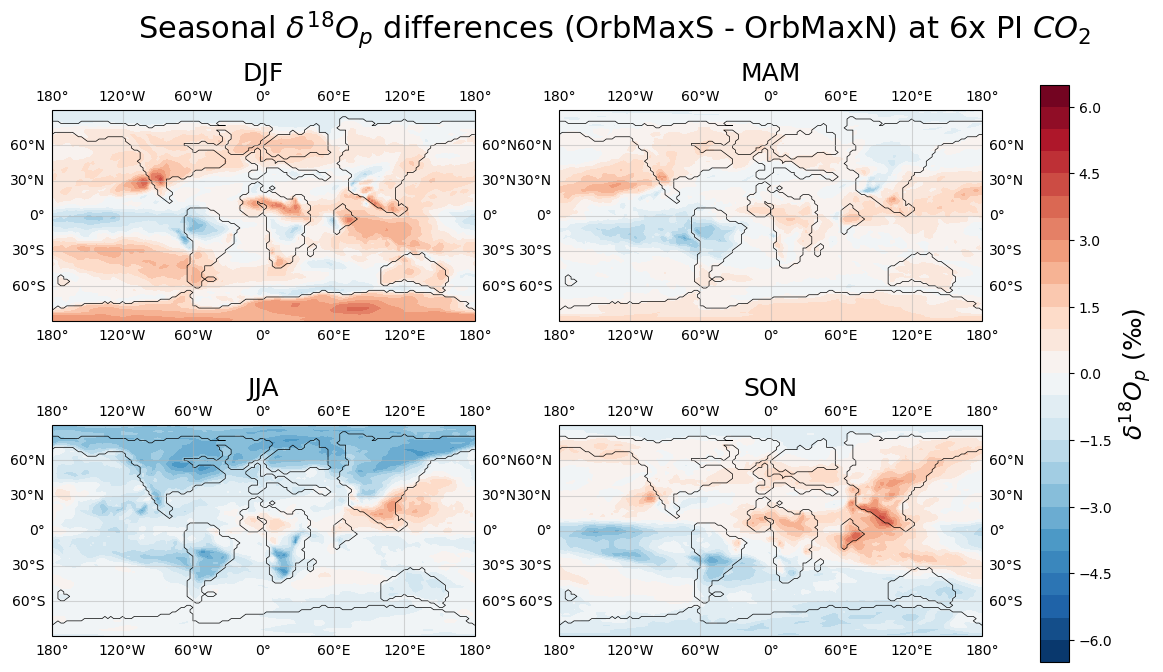

In [6]:
# water isotope plots at higher CO2

orbmaxn_SH = delta_18O(cam_OrbMaxN_6x).groupby("time.season").mean(dim=["time"])
orbmaxs_SH = delta_18O(cam_OrbMaxS_6x).groupby("time.season").mean(dim=["time"])
diffs = [orbmaxs_SH.sel(season=season) - orbmaxn_SH.sel(season=season) for season in SEASONS]
diffs = [cyclitize(d) for d in diffs]
vmax = max(max(abs(float(d.max())), abs(float(d.min()))) for d in diffs)

fig, axes = plt.subplots(ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(15,7.5))
bounds = np.linspace(-6.5, 6.5, 27)
contours = []
for season, ax, diff in zip(SEASONS, axes.flat, diffs):
    contour = ax.contourf(
        diff.lon,
        diff.lat,
        diff,
        transform=ccrs.PlateCarree(),
        cmap="RdBu_r",
        levels=bounds,
        vmin=-6.5,
        vmax=6.5,
    )
    contours.append(contour)
    plot_land(ax, land)
    ax.set_global()
    ax.gridlines(draw_labels=True, alpha=0.5)
    ax.set_title(season, size=18)

cbar = fig.colorbar(contour, ax=axes.ravel().tolist())
cbar.set_label("$\\delta^{18}O_p$ ($\perthousand$)",size=18)
fig.suptitle("Seasonal $\\delta^{18}O_p$ differences (OrbMaxS - OrbMaxN) at 6x PI $CO_2$", size=22)
fig.savefig("fig8new")
plt.show()

In [7]:
def read_clm_data(
    path: str,
    with_fixed_dates: bool = True,
    with_extra_data: bool = True,
) -> xr.Dataset:
    """
    Reads in a clm dataset and prescribes dates.
    """
    data = xr.open_dataset(path)
    if with_fixed_dates:
        data = fix_dates(data)
    return data

In [8]:
# load in land data

clm_OrbMaxN_3x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.OrbMaxN.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMaxS_3x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.OrbMaxS.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMin_3x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.OrbMin.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMod_3x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM03x.03.clm2.h0.2101-2200.climo.nc")

clm_OrbMaxN_6x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.OrbMaxN.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMaxS_6x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.OrbMaxS.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMin_6x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.OrbMin.01.clm2.h0.2601-2700.climo.nc")
clm_OrbMod_6x = read_clm_data(f"{DATA_PATH}/b.e12.B1850C5CN.f19_g16.iPETM06x.09.clm2.h0.2101-2200.climo.nc")

In [9]:
def d_18O(clm_data: xr.Dataset) -> xr.DataArray:
    """
    Compute the d18O of soil from CLM output.
    """
    p16O = (
        clm_data.H2OSOI_H2OTR
    )
    p18O = (
        clm_data.H2OSOI_H218O
    )
    d18Op = (p18O / p16O - 1) * 1000
    d18Op.attrs["units"] = "per mil"
    d18Op.attrs["name"] = "$\\delta^{18}O$ of soil"
    return d18Op

def delta_d(clm_data: xr.Dataset) -> xr.DataArray:
    """
    Calculate delta D (dD) of soil from CLM output.
    """
    p16o = (
        clm_data.H2OSOI_H2OTR
    )
    Ds = (
        clm_data.H2OSOI_HDO
    )
    dDs = (Ds / p16o - 1) * 1000.0
    dDs.attrs["units"] = "per mil"
    dDs.attrs["name"] = "$\\delta D$ of soil"
    return dDs

In [10]:
# take data only at depths 40-100 cm

clm_OrbMaxN_3x_sliced = clm_OrbMaxN_3x.sel(levgrnd=slice(0.4,1))
clm_OrbMaxS_3x_sliced = clm_OrbMaxS_3x.sel(levgrnd=slice(0.4,1))
clm_OrbMin_3x_sliced = clm_OrbMin_3x.sel(levgrnd=slice(0.4,1.1))
clm_OrbMod_3x_sliced = clm_OrbMod_3x.sel(levgrnd=slice(0.4,1.1))
clm_OrbMaxN_6x_sliced = clm_OrbMaxN_6x.sel(levgrnd=slice(0.4,1))
clm_OrbMaxS_6x_sliced = clm_OrbMaxS_6x.sel(levgrnd=slice(0.4,1))
clm_OrbMin_6x_sliced = clm_OrbMin_6x.sel(levgrnd=slice(0.4,1))
clm_OrbMod_6x_sliced = clm_OrbMod_6x.sel(levgrnd=slice(0.4,1))

# slicing 40 to 100 cm for soil carbonates
# slicing 30 to 100 cm for leaf wax

In [11]:
# define orbital data

mean_OrbMaxN_6x = (
        d_18O(clm_OrbMaxN_6x_sliced)
        .mean(dim=["time","lon","levgrnd"])
)
max_OrbMaxN_6x = (
        d_18O(clm_OrbMaxN_6x_sliced)
        .mean(dim="levgrnd")
        .max(dim=["time","lon"])
)
min_OrbMaxN_6x = (
        d_18O(clm_OrbMaxN_6x_sliced)
        .mean(dim="levgrnd")
        .min(dim=["time","lon"])
)

mean_OrbMaxS_6x = (
        d_18O(clm_OrbMaxS_6x_sliced)
        .mean(dim=["time","lon","levgrnd"])
)
max_OrbMaxS_6x = (
        d_18O(clm_OrbMaxS_6x_sliced)
        .mean(dim="levgrnd")
        .max(dim=["time","lon"])
)
min_OrbMaxS_6x = (
        d_18O(clm_OrbMaxS_6x_sliced)
        .mean(dim="levgrnd")
        .min(dim=["time","lon"])
)

mean_OrbMin_6x = (
        d_18O(clm_OrbMin_6x_sliced)
        .mean(dim=["time","lon","levgrnd"])
)
max_OrbMin_6x = (
        d_18O(clm_OrbMin_6x_sliced)
        .mean(dim="levgrnd")
        .max(dim=["time","lon"])
)
min_OrbMin_6x = (
        d_18O(clm_OrbMin_6x_sliced)
        .mean(dim="levgrnd")
        .min(dim=["time","lon"])
)

mean_OrbMod_6x = (
        d_18O(clm_OrbMod_6x_sliced)
        .mean(dim=["time","lon","levgrnd"])
)
max_OrbMod_6x = (
        d_18O(clm_OrbMod_6x_sliced)
        .mean(dim="levgrnd")
        .max(dim=["time","lon"])
)
min_OrbMod_6x = (
        d_18O(clm_OrbMod_6x_sliced)
        .mean(dim="levgrnd")
        .min(dim=["time","lon"])
)

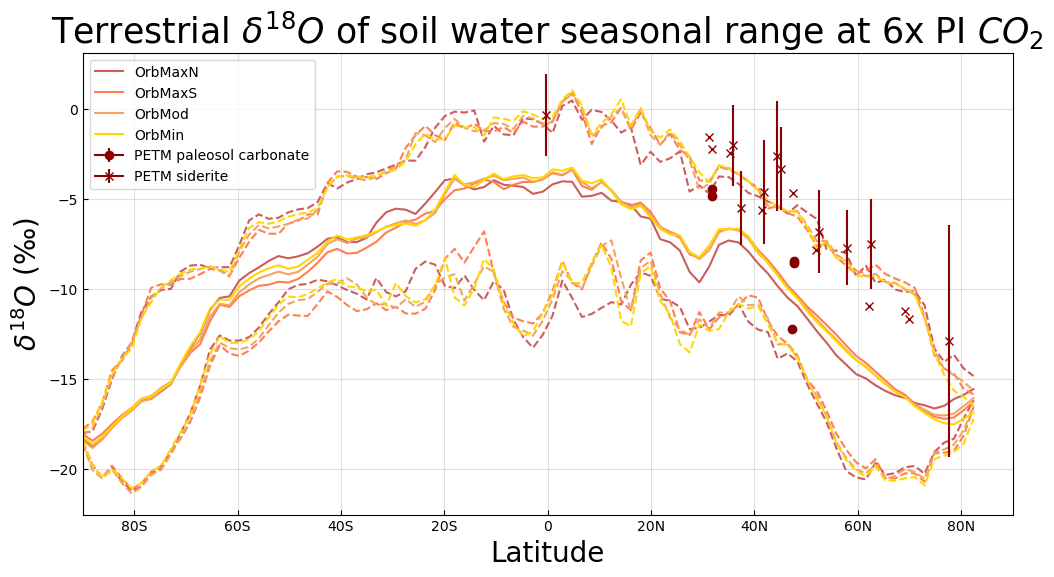

In [12]:
# model-data comparison for soil carbonate water isotopes

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.plot(mean_OrbMaxN_6x.lat, mean_OrbMaxN_6x, color="indianred", label="OrbMaxN")
ax.plot(mean_OrbMaxN_6x.lat, min_OrbMaxN_6x, color="indianred", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, max_OrbMaxN_6x, color="indianred", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, mean_OrbMaxS_6x, color="coral", label="OrbMaxS")
ax.plot(mean_OrbMaxN_6x.lat, min_OrbMaxS_6x, color="coral", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, max_OrbMaxS_6x, color="coral", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, mean_OrbMod_6x, color="sandybrown", label="OrbMod")
ax.plot(mean_OrbMaxN_6x.lat, min_OrbMod_6x, color="sandybrown", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, max_OrbMod_6x, color="sandybrown", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, mean_OrbMin_6x, color="gold", label="OrbMin")
ax.plot(mean_OrbMaxN_6x.lat, min_OrbMin_6x, color="gold", linestyle="--")
ax.plot(mean_OrbMaxN_6x.lat, max_OrbMin_6x, color="gold", linestyle="--")
plt.errorbar(31.73, -4.42, 0, color='darkred',marker='o',alpha=1,label='PETM paleosol carbonate')
plt.errorbar(47.71, -8.44, 0, color='darkred',marker='o',alpha=1)
plt.errorbar(31.81, -4.83, 0, color='darkred',marker='o',alpha=1)
plt.errorbar(47.76, -8.54, 0, color='darkred',marker='o',alpha=1)
plt.errorbar(47.21, -12.23, 0, color='darkred',marker='o',alpha=1)
plt.errorbar(31.24, -1.55, 0, color='darkred',marker='x',alpha=1,label='PETM siderite')
plt.errorbar(31.87, -2.22, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(35.34, -2.42, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(41.42, -5.6, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(47.49, -4.64, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(51.94, -7.82, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(69.94, -11.69, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(69.14, -11.21, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(62.11, -10.92, 0, color='darkred',marker='x',alpha=1)
plt.errorbar(57.88, -7.7, 2.07, color='darkred',marker='x',alpha=1)
plt.errorbar(37.36, -5.5, 2.06, color='darkred',marker='x',alpha=1)
plt.errorbar(77.69, -12.9, 6.44, color='darkred',marker='x',alpha=1)
plt.errorbar(35.8, -2, 2.25, color='darkred',marker='x',alpha=1)
plt.errorbar(52.49, -6.8, 2.3, color='darkred',marker='x',alpha=1)
plt.errorbar(62.66, -7.5, 2.51, color='darkred',marker='x',alpha=1)
plt.errorbar(-0.24, -0.3, 2.29, color='darkred',marker='x',alpha=1)
plt.errorbar(41.92, -4.6, 2.9, color='darkred',marker='x',alpha=1)
plt.errorbar(45.15, -3.3, 2.32, color='darkred',marker='x',alpha=1)
plt.errorbar(44.3, -2.6, 3.07, color='darkred',marker='x',alpha=1)
#plt.errorbar(31.73, -5, 0, color='darkgoldenrod',marker='o',alpha=1,label='Early Eocene Paleosol Carbonate')
#plt.errorbar(46.54, -8.8, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(44.39, -5.8, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(45.16, -8.3, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(31.81, -4.6, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(48.19, -7.3, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(47.1, -8.6, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(47.49, -8, 0, color='darkgoldenrod',marker='o',alpha=1)
#plt.errorbar(29.5, -5, 0, color='darkgoldenrod',marker='o',alpha=1)
zonal_plot_style(ax)
ax.set_ylabel("$\delta^{18}O$ ($\perthousand$)", size=20)
ax.set_xlabel("Latitude", size=20)
ax.set_title("Terrestrial $\delta^{18}O$ of soil water seasonal range at 6x PI $CO_2$", size=25)
ax.legend(loc='upper left')
plt.show()
fig.savefig('fig09')

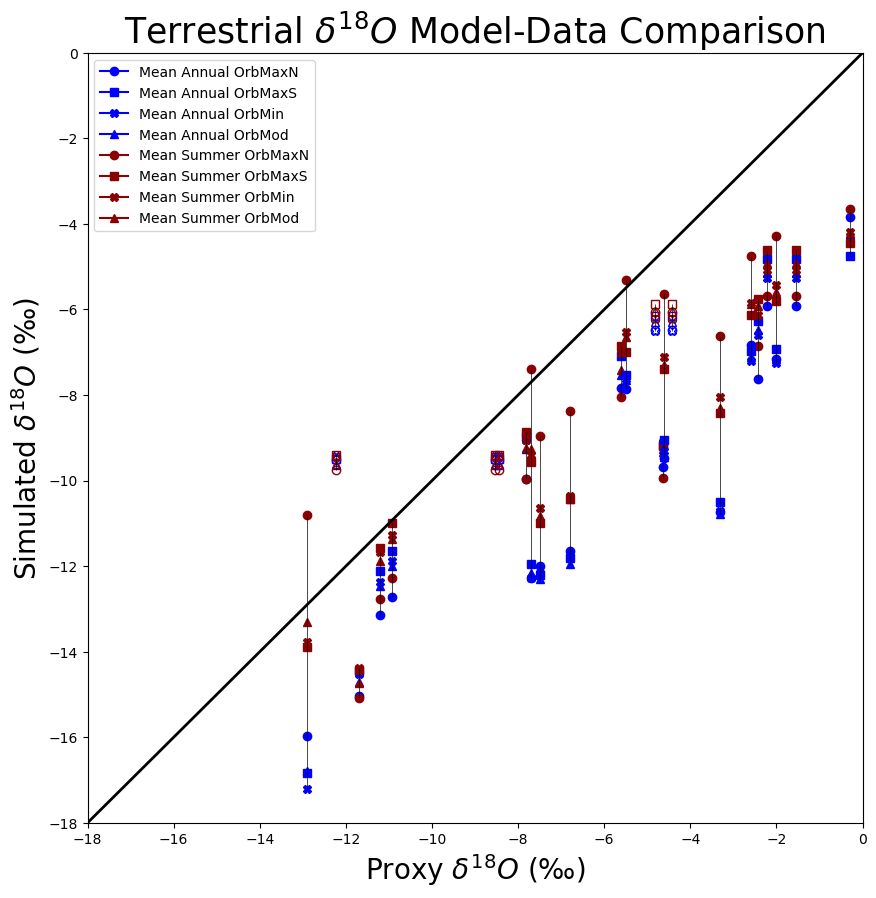

In [13]:
# model-data comparison to understand seasonal bias 

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

plt.plot(-4.42, -6.47, color='blue',marker='o',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.15, color='blue',marker='s',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.5, color='blue',marker='X',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.3, color='blue',marker='^',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.05, color='darkred',marker='o',alpha=1,fillstyle='none')
plt.plot(-4.42, -5.87, color='darkred',marker='s',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.22, color='darkred',marker='X',alpha=1,fillstyle='none')
plt.plot(-4.42, -6.04, color='darkred',marker='^',alpha=1,fillstyle='none')
plt.vlines(x=-4.42,ymin=-6.5,ymax=-5.87, color="black", linestyle="-", linewidth=0.5)

plt.plot(-8.44, -9.53, color='blue',marker='o',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.5, color='blue',marker='s',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.43, color='blue',marker='X',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.63, color='blue',marker='^',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.76, color='darkred',marker='o',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.41, color='darkred',marker='s',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.45, color='darkred',marker='X',alpha=1, fillstyle='none')
plt.plot(-8.44, -9.61, color='darkred',marker='^',alpha=1, fillstyle='none')
plt.vlines(x=-8.44,ymin=-9.76,ymax=-9.41, color="black", linestyle="-", linewidth=0.5)

plt.plot(-4.83, -6.47, color='blue',marker='o',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.15, color='blue',marker='s',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.5, color='blue',marker='X',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.3, color='blue',marker='^',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.05, color='darkred',marker='o',alpha=1, fillstyle='none')
plt.plot(-4.83, -5.87, color='darkred',marker='s',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.22, color='darkred',marker='X',alpha=1, fillstyle='none')
plt.plot(-4.83, -6.04, color='darkred',marker='^',alpha=1, fillstyle='none')
plt.vlines(x=-4.83,ymin=-6.5,ymax=-5.87, color="black", linestyle="-", linewidth=0.5)

plt.plot(-8.54, -9.53, color='blue',marker='o',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.5, color='blue',marker='s',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.43, color='blue',marker='X',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.63, color='blue',marker='^',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.76, color='darkred',marker='o',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.41, color='darkred',marker='s',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.45, color='darkred',marker='X',alpha=1, fillstyle='none')
plt.plot(-8.54, -9.61, color='darkred',marker='^',alpha=1, fillstyle='none')
plt.vlines(x=-8.54,ymin=-9.76,ymax=-9.41, color="black", linestyle="-", linewidth=0.5)

plt.plot(-12.23, -9.53, color='blue',marker='o',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.5, color='blue',marker='s',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.43, color='blue',marker='X',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.63, color='blue',marker='^',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.76, color='darkred',marker='o',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.41, color='darkred',marker='s',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.45, color='darkred',marker='X',alpha=1, fillstyle='none')
plt.plot(-12.23, -9.61, color='darkred',marker='^',alpha=1, fillstyle='none')
plt.vlines(x=-12.23,ymin=-9.76,ymax=-9.41, color="black", linestyle="-", linewidth=0.5)

plt.plot(-1.55, -5.93, color='blue',marker='o',alpha=1, label='Mean Annual OrbMaxN')
plt.plot(-1.55, -4.81, color='blue',marker='s',alpha=1, label='Mean Annual OrbMaxS')
plt.plot(-1.55, -5.27, color='blue',marker='X',alpha=1, label='Mean Annual OrbMin')
plt.plot(-1.55, -5.14, color='blue',marker='^',alpha=1, label='Mean Annual OrbMod')
plt.plot(-1.55, -5.69, color='darkred',marker='o',alpha=1, label='Mean Summer OrbMaxN')
plt.plot(-1.55, -4.62, color='darkred',marker='s',alpha=1, label='Mean Summer OrbMaxS')
plt.plot(-1.55, -5.07, color='darkred',marker='X',alpha=1, label='Mean Summer OrbMin')
plt.plot(-1.55, -4.92, color='darkred',marker='^',alpha=1, label='Mean Summer OrbMod')
plt.vlines(x=-1.55,ymin=-5.93,ymax=-4.62, color="black", linestyle="-", linewidth=0.5)

plt.plot(-2.22, -5.93, color='blue',marker='o',alpha=1)
plt.plot(-2.22, -4.81, color='blue',marker='s',alpha=1)
plt.plot(-2.22, -5.27, color='blue',marker='X',alpha=1)
plt.plot(-2.22, -5.14, color='blue',marker='^',alpha=1)
plt.plot(-2.22, -5.69, color='darkred',marker='o',alpha=1)
plt.plot(-2.22, -4.62, color='darkred',marker='s',alpha=1)
plt.plot(-2.22, -5.07, color='darkred',marker='X',alpha=1)
plt.plot(-2.22, -4.92, color='darkred',marker='^',alpha=1)
plt.vlines(x=-2.22,ymin=-5.93,ymax=-4.62, color="black", linestyle="-", linewidth=0.5)

plt.plot(-2.42, -7.63, color='blue',marker='o',alpha=1)
plt.plot(-2.42, -6.26, color='blue',marker='s',alpha=1)
plt.plot(-2.42, -6.6, color='blue',marker='X',alpha=1)
plt.plot(-2.42, -6.47, color='blue',marker='^',alpha=1)
plt.plot(-2.42, -6.86, color='darkred',marker='o',alpha=1)
plt.plot(-2.42, -5.76, color='darkred',marker='s',alpha=1)
plt.plot(-2.42, -6.13, color='darkred',marker='X',alpha=1)
plt.plot(-2.42, -5.93, color='darkred',marker='^',alpha=1)
plt.vlines(x=-2.42,ymin=-7.63,ymax=-5.76, color="black", linestyle="-", linewidth=0.5)

plt.plot(-5.6, -7.84, color='blue',marker='o',alpha=1)
plt.plot(-5.6, -7.08, color='blue',marker='s',alpha=1)
plt.plot(-5.6, -7.08, color='blue',marker='X',alpha=1)
plt.plot(-5.6, -7.52, color='blue',marker='^',alpha=1)
plt.plot(-5.6, -8.04, color='darkred',marker='o',alpha=1)
plt.plot(-5.6, -6.86, color='darkred',marker='s',alpha=1)
plt.plot(-5.6, -7.01, color='darkred',marker='X',alpha=1)
plt.plot(-5.6, -7.41, color='darkred',marker='^',alpha=1)
plt.vlines(x=-5.6,ymin=-8.04,ymax=-6.86, color="black", linestyle="-", linewidth=0.5)

plt.plot(-4.64, -9.68, color='blue',marker='o',alpha=1)
plt.plot(-4.64, -9.17, color='blue',marker='s',alpha=1)
plt.plot(-4.64, -9.1, color='blue',marker='X',alpha=1)
plt.plot(-4.64, -9.25, color='blue',marker='^',alpha=1)
plt.plot(-4.64, -9.94, color='darkred',marker='o',alpha=1)
plt.plot(-4.64, -9.19, color='darkred',marker='s',alpha=1)
plt.plot(-4.64, -9.22, color='darkred',marker='X',alpha=1)
plt.plot(-4.64, -9.32, color='darkred',marker='^',alpha=1)
plt.vlines(x=-4.64,ymin=-9.94,ymax=-9.1, color="black", linestyle="-", linewidth=0.5)

plt.plot(-7.82, -9.97, color='blue',marker='o',alpha=1)
plt.plot(-7.82, -8.98, color='blue',marker='s',alpha=1)
plt.plot(-7.82, -9.06, color='blue',marker='X',alpha=1)
plt.plot(-7.82, -9.26, color='blue',marker='^',alpha=1)
plt.plot(-7.82, -9.97, color='darkred',marker='o',alpha=1)
plt.plot(-7.82, -8.87, color='darkred',marker='s',alpha=1)
plt.plot(-7.82, -9.05, color='darkred',marker='X',alpha=1)
plt.plot(-7.82, -9.23, color='darkred',marker='^',alpha=1)
plt.vlines(x=-7.82,ymin=-9.97,ymax=-8.87, color="black", linestyle="-", linewidth=0.5)

plt.plot(-11.69, -15.03, color='blue',marker='o',alpha=1)
plt.plot(-11.69, -14.44, color='blue',marker='s',alpha=1)
plt.plot(-11.69, -14.52, color='blue',marker='X',alpha=1)
plt.plot(-11.69, -14.71, color='blue',marker='^',alpha=1)
plt.plot(-11.69, -15.09, color='darkred',marker='o',alpha=1)
plt.plot(-11.69, -14.43, color='darkred',marker='s',alpha=1)
plt.plot(-11.69, -14.38, color='darkred',marker='X',alpha=1)
plt.plot(-11.69, -14.74, color='darkred',marker='^',alpha=1)
plt.vlines(x=-11.69,ymin=-15.09,ymax=-14.38, color="black", linestyle="-", linewidth=0.5)

plt.plot(-11.21, -13.15, color='blue',marker='o',alpha=1)
plt.plot(-11.21, -12.12, color='blue',marker='s',alpha=1)
plt.plot(-11.21, -12.38, color='blue',marker='X',alpha=1)
plt.plot(-11.21, -12.47, color='blue',marker='^',alpha=1)
plt.plot(-11.21, -12.77, color='darkred',marker='o',alpha=1)
plt.plot(-11.21, -11.58, color='darkred',marker='s',alpha=1)
plt.plot(-11.21, -11.66, color='darkred',marker='X',alpha=1)
plt.plot(-11.21, -11.88, color='darkred',marker='^',alpha=1)
plt.vlines(x=-11.21,ymin=-13.15,ymax=-11.66, color="black", linestyle="-", linewidth=0.5)

plt.plot(-10.92, -12.73, color='blue',marker='o',alpha=1)
plt.plot(-10.92, -11.64, color='blue',marker='s',alpha=1)
plt.plot(-10.92, -11.89, color='blue',marker='X',alpha=1)
plt.plot(-10.92, -11.99, color='blue',marker='^',alpha=1)
plt.plot(-10.92, -12.27, color='darkred',marker='o',alpha=1)
plt.plot(-10.92, -11, color='darkred',marker='s',alpha=1)
plt.plot(-10.92, -11.28, color='darkred',marker='X',alpha=1)
plt.plot(-10.92, -11.37, color='darkred',marker='^',alpha=1)
plt.vlines(x=-10.92,ymin=-12.73,ymax=-11, color="black", linestyle="-", linewidth=0.5)

plt.plot(-7.7, -12.27, color='blue',marker='o',alpha=1)
plt.plot(-7.7, -11.96, color='blue',marker='s',alpha=1)
plt.plot(-7.7, -12.28, color='blue',marker='X',alpha=1)
plt.plot(-7.7, -12.17, color='blue',marker='^',alpha=1)
plt.plot(-7.7, -7.4, color='darkred',marker='o',alpha=1)
plt.plot(-7.7, -9.57, color='darkred',marker='s',alpha=1)
plt.plot(-7.7, -9.39, color='darkred',marker='X',alpha=1)
plt.plot(-7.7, -9.27, color='darkred',marker='^',alpha=1)
plt.vlines(x=-7.7,ymin=-12.28,ymax=-7.4, color="black", linestyle="-", linewidth=0.5)

plt.plot(-5.5, -7.87, color='blue',marker='o',alpha=1)
plt.plot(-5.5, -7.54, color='blue',marker='s',alpha=1)
plt.plot(-5.5, -7.63, color='blue',marker='X',alpha=1)
plt.plot(-5.5, -7.65, color='blue',marker='^',alpha=1)
plt.plot(-5.5, -5.32, color='darkred',marker='o',alpha=1)
plt.plot(-5.5, -7, color='darkred',marker='s',alpha=1)
plt.plot(-5.5, -6.52, color='darkred',marker='X',alpha=1)
plt.plot(-5.5, -6.65, color='darkred',marker='^',alpha=1)
plt.vlines(x=-5.5,ymin=-7.87,ymax=-5.32, color="black", linestyle="-", linewidth=0.5)

plt.plot(-12.9, -15.96, color='blue',marker='o',alpha=1)
plt.plot(-12.9, -16.83, color='blue',marker='s',alpha=1)
plt.plot(-12.9, -17.22, color='blue',marker='X',alpha=1)
plt.plot(-12.9, -16.8, color='blue',marker='^',alpha=1)
plt.plot(-12.9, -10.8, color='darkred',marker='o',alpha=1)
plt.plot(-12.9, -13.9, color='darkred',marker='s',alpha=1)
plt.plot(-12.9, -13.77, color='darkred',marker='X',alpha=1)
plt.plot(-12.9, -13.3, color='darkred',marker='^',alpha=1)
plt.vlines(x=-12.9,ymin=-17.22,ymax=-10.8, color="black", linestyle="-", linewidth=0.5)

plt.plot(-2, -7.16, color='blue',marker='o',alpha=1)
plt.plot(-2, -6.93, color='blue',marker='s',alpha=1)
plt.plot(-2, -7.25, color='blue',marker='X',alpha=1)
plt.plot(-2, -7.16, color='blue',marker='^',alpha=1)
plt.plot(-2, -4.28, color='darkred',marker='o',alpha=1)
plt.plot(-2, -5.81, color='darkred',marker='s',alpha=1)
plt.plot(-2, -5.43, color='darkred',marker='X',alpha=1)
plt.plot(-2, -5.58, color='darkred',marker='^',alpha=1)
plt.vlines(x=-2,ymin=-7.25,ymax=-4.28, color="black", linestyle="-", linewidth=0.5)

plt.plot(-6.8, -11.64, color='blue',marker='o',alpha=1)
plt.plot(-6.8, -11.81, color='blue',marker='s',alpha=1)
plt.plot(-6.8, -11.77, color='blue',marker='X',alpha=1)
plt.plot(-6.8, -11.96, color='blue',marker='^',alpha=1)
plt.plot(-6.8, -8.38, color='darkred',marker='o',alpha=1)
plt.plot(-6.8, -10.44, color='darkred',marker='s',alpha=1)
plt.plot(-6.8, -10.37, color='darkred',marker='X',alpha=1)
plt.plot(-6.8, -10.42, color='darkred',marker='^',alpha=1)
plt.vlines(x=-6.8,ymin=-11.96,ymax=-8.38, color="black", linestyle="-", linewidth=0.5)

plt.plot(-7.5, -12, color='blue',marker='o',alpha=1)
plt.plot(-7.5, -12.2, color='blue',marker='s',alpha=1)
plt.plot(-7.5, -12.15, color='blue',marker='X',alpha=1)
plt.plot(-7.5, -12.29, color='blue',marker='^',alpha=1)
plt.plot(-7.5, -8.95, color='darkred',marker='o',alpha=1)
plt.plot(-7.5, -10.99, color='darkred',marker='s',alpha=1)
plt.plot(-7.5, -10.65, color='darkred',marker='X',alpha=1)
plt.plot(-7.5, -10.82, color='darkred',marker='^',alpha=1)
plt.vlines(x=-7.5,ymin=-12.29,ymax=-8.95, color="black", linestyle="-", linewidth=0.5)

plt.plot(-0.3, -3.83, color='blue',marker='o',alpha=1)
plt.plot(-0.3, -4.74, color='blue',marker='s',alpha=1)
plt.plot(-0.3, -4.37, color='blue',marker='X',alpha=1)
plt.plot(-0.3, -4.42, color='blue',marker='^',alpha=1)
plt.plot(-0.3, -3.65, color='darkred',marker='o',alpha=1)
plt.plot(-0.3, -4.44, color='darkred',marker='s',alpha=1)
plt.plot(-0.3, -4.2, color='darkred',marker='X',alpha=1)
plt.plot(-0.3, -4.21, color='darkred',marker='^',alpha=1)
plt.vlines(x=-0.3,ymin=-4.74,ymax=-3.65, color="black", linestyle="-", linewidth=0.5)

plt.plot(-4.6, -9.48, color='blue',marker='o',alpha=1)
plt.plot(-4.6, -9.04, color='blue',marker='s',alpha=1)
plt.plot(-4.6, -9.3, color='blue',marker='X',alpha=1)
plt.plot(-4.6, -9.45, color='blue',marker='^',alpha=1)
plt.plot(-4.6, -5.63, color='darkred',marker='o',alpha=1)
plt.plot(-4.6, -7.38, color='darkred',marker='s',alpha=1)
plt.plot(-4.6, -7.11, color='darkred',marker='X',alpha=1)
plt.plot(-4.6, -7.29, color='darkred',marker='^',alpha=1)
plt.vlines(x=-4.6,ymin=-9.48,ymax=-5.63, color="black", linestyle="-", linewidth=0.5)

plt.plot(-3.3, -10.74, color='blue',marker='o',alpha=1)
plt.plot(-3.3, -10.51, color='blue',marker='s',alpha=1)
plt.plot(-3.3, -10.7, color='blue',marker='X',alpha=1)
plt.plot(-3.3, -10.77, color='blue',marker='^',alpha=1)
plt.plot(-3.3, -6.63, color='darkred',marker='o',alpha=1)
plt.plot(-3.3, -8.43, color='darkred',marker='s',alpha=1)
plt.plot(-3.3, -8.04, color='darkred',marker='X',alpha=1)
plt.plot(-3.3, -8.31, color='darkred',marker='^',alpha=1)
plt.vlines(x=-3.3,ymin=-10.77,ymax=-6.63, color="black", linestyle="-", linewidth=0.5)

plt.plot(-2.6, -6.82, color='blue',marker='o',alpha=1)
plt.plot(-2.6, -6.96, color='blue',marker='s',alpha=1)
plt.plot(-2.6, -7.2, color='blue',marker='X',alpha=1)
plt.plot(-2.6, -7.1, color='blue',marker='^',alpha=1)
plt.plot(-2.6, -4.75, color='darkred',marker='o',alpha=1)
plt.plot(-2.6, -6.14, color='darkred',marker='s',alpha=1)
plt.plot(-2.6, -5.84, color='darkred',marker='X',alpha=1)
plt.plot(-2.6, -5.86, color='darkred',marker='^',alpha=1)
plt.vlines(x=-2.6,ymin=-7.2,ymax=-4.75, color="black", linestyle="-", linewidth=0.5)

plt.axline((-18,-18), slope=1, color="black", linestyle="-", linewidth=2)

plt.ylim(-18,0)
plt.xlim(-18,0)

ax.set_ylabel("Simulated $\delta^{18}O$ ($\perthousand$)", size=20)
ax.set_xlabel("Proxy $\delta^{18}O$ ($\perthousand$)", size=20)
ax.set_title("Terrestrial $\delta^{18}O$ Model-Data Comparison", size=25)
ax.legend(loc='upper left')
plt.show()
fig.savefig("new_lines_both_d18O")